In [56]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize


import keras
import tensorflow as tf

from keras import layers, models, ops
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split


# Loading the Dataset

In [2]:
file_path = '/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv'

names = ['class']

names.extend([i for i in range(1, 785)])

df = pd.read_csv(file_path, header=None, names=names)

df.shape

(372451, 785)

In [3]:
df.head()

,class,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y_full = df['class']
x_full = df.drop('class', axis=1).values.reshape(-1, 28, 28, 1)

In [5]:
print('X shape: ' + str(x_full.shape))
print('Y shape: ' + str(y_full.shape))

X shape: (372451, 28, 28, 1)
Y shape: (372451,)


In [6]:
print([x_full.min(), x_full.max()])

[0, 255]


# Splitting Dataset

In [7]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in splitter.split(x_full, y_full):
    x_train_full, y_train_full = x_full[train_idx], y_full.iloc[train_idx].values
    x_test, y_test = x_full[test_idx], y_full.iloc[test_idx].values

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full,
    y_train_full,
    test_size=0.1,
    stratify=y_train_full,
    random_state=42
)

'''
X_train, Y_train => 72% of the dataset
X_valid, Y_valid => 8% of the dataset
X_test, Y_test => 20% of the dataset

'''

'\nX_train, Y_train => 72% of the dataset\nX_valid, Y_valid => 8% of the dataset\nX_test, Y_test => 20% of the dataset\n\n'

# Data Preprocessing & Augmentation

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=20, # Randomized Rotation between -20 & 20
    width_shift_range=0.15, # Randomized Shifting Over X-axis between -.15 & .15
    height_shift_range=0.15, # Randomized Shifting Over Y-axis between -.15 & .15
    zoom_range=0.20, # Randomized Zoom between -.20 & .20
    rescale=1./255, # Normalize Every Pixel in the image to be between [0, 1]
)

In [11]:
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

In [12]:
train_loader = train_datagen.flow(
    x_train, y_train,
    batch_size=32,
    shuffle=True
)

In [13]:
valid_loader = valid_datagen.flow(
    x_valid, y_valid,
    batch_size=32,
    shuffle=False
)

In [14]:
test_loader = test_datagen.flow(
    x_test, y_test,
    batch_size=32,
    shuffle=False
)

# Building the pretrained Inception V4 (ResNet)

In [15]:
def build_resnet_model(num_classes=26):
    model = models.Sequential(name="ResNet50V2_Transfer")

    model.add(layers.InputLayer(input_shape=(28, 28, 1)))


    model.add(layers.Resizing(32, 32, interpolation='bilinear'))
    

    model.add(layers.Conv2D(3, (1, 1), name="grayscale_to_rgb"))
    
    base_model = keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet",
        pooling='avg'
    )
    

    base_model.trainable = False
    
    model.add(base_model)

    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [25]:
resnetModel = build_resnet_model(num_classes=26) 


resnetModel.summary()

Model: "ResNet50V2_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ grayscale_to_rgb (Conv2D)       │ (None, 32, 32, 3)      │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,682,912 (94.16 MB)

 Trainable params: 1,118,112 (4.27 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [38]:
baseResnetModel = resnetModel.layers[2]
baseResnetModel.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, None,      │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, None,      │          0 │ conv2_block1_pre… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, None,      │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, None,      │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

# Phase#1 Train The Top Layers Of The Model (Classification layer)

In [26]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [27]:
resnetModel.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history_stage_1 = resnetModel.fit(
    train_loader,
    validation_data=valid_loader,
    epochs=50,
    callbacks=[early_stop],
)

Epoch 1/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 142s 16ms/step - accuracy: 0.5660 - loss: 1.4676 - val_accuracy: 0.8125 - val_loss: 0.6249
Epoch 2/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 122s 14ms/step - accuracy: 0.6858 - loss: 1.0414 - val_accuracy: 0.8206 - val_loss: 0.5910
Epoch 3/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 122s 15ms/step - accuracy: 0.7063 - loss: 0.9761 - val_accuracy: 0.8185 - val_loss: 0.5847
Epoch 4/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 121s 14ms/step - accuracy: 0.7163 - loss: 0.9459 - val_accuracy: 0.8273 - val_loss: 0.5632
Epoch 5/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 121s 14ms/step - accuracy: 0.7201 - loss: 0.9250 - val_accuracy: 0.8385 - val_loss: 0.5287
Epoch 6/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 121s 14ms/step - accuracy: 0.7295 - loss: 0.9044 - val_accuracy: 0.8439 - val_loss: 0.5241
Epoch 7/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 121s 14ms/step - accuracy: 0.7296 - loss: 0.9036 - val_accuracy: 0.8428 - val_loss: 0.5180
Epoch 8/50
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 121s 14ms/step - accuracy: 

# Phase#2 Train The Top Layers Of The Base Model (ResNet)

In [43]:
fine_tune_at = len(baseResnetModel.layers) - 20

# Freeze all the layers before the 'fine_tune_at' layer
for layer in baseResnetModel.layers[:fine_tune_at]:
    layer.trainable = False

In [44]:
resnetModel.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history_stage_2 = resnetModel.fit(
    train_loader,
    validation_data=valid_loader,
    epochs=20,
    callbacks=[early_stop],
)

Epoch 1/20
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 143s 16ms/step - accuracy: 0.7662 - loss: 0.7895 - val_accuracy: 0.8680 - val_loss: 0.4411
Epoch 2/20
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 122s 15ms/step - accuracy: 0.7749 - loss: 0.7657 - val_accuracy: 0.8688 - val_loss: 0.4359
Epoch 3/20
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 122s 15ms/step - accuracy: 0.7755 - loss: 0.7608 - val_accuracy: 0.8700 - val_loss: 0.4321
Epoch 4/20
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 122s 15ms/step - accuracy: 0.7785 - loss: 0.7540 - val_accuracy: 0.8697 - val_loss: 0.4306
Epoch 5/20
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 122s 15ms/step - accuracy: 0.7809 - loss: 0.7462 - val_accuracy: 0.8697 - val_loss: 0.4293
Epoch 6/20
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 122s 15ms/step - accuracy: 0.7791 - loss: 0.7446 - val_accuracy: 0.8700 - val_loss: 0.4290
Epoch 7/20
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 123s 15ms/step - accuracy: 0.7832 - loss: 0.7366 - val_accuracy: 0.8705 - val_loss: 0.4281
Epoch 8/20
8381/8381 ━━━━━━━━━━━━━━━━━━━━ 123s 15ms/step - accuracy: 

# Model Evaluation


**1- Accuaracy**

In [45]:
test_loss, test_acc = resnetModel.evaluate(test_loader)

print("Test Accuracy =", test_acc)

2328/2328 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.8771 - loss: 0.4121
Test Accuracy = 0.8770186901092529


In [46]:
y_pred_probs = resnetModel.predict(test_loader)

y_pred = np.argmax(y_pred_probs, axis=1)

2328/2328 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step


**2- Precision, Recall, F1-score**

In [49]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.8627
Recall: 0.8215
F1-score: 0.8391


**3- Confusion Matrix**

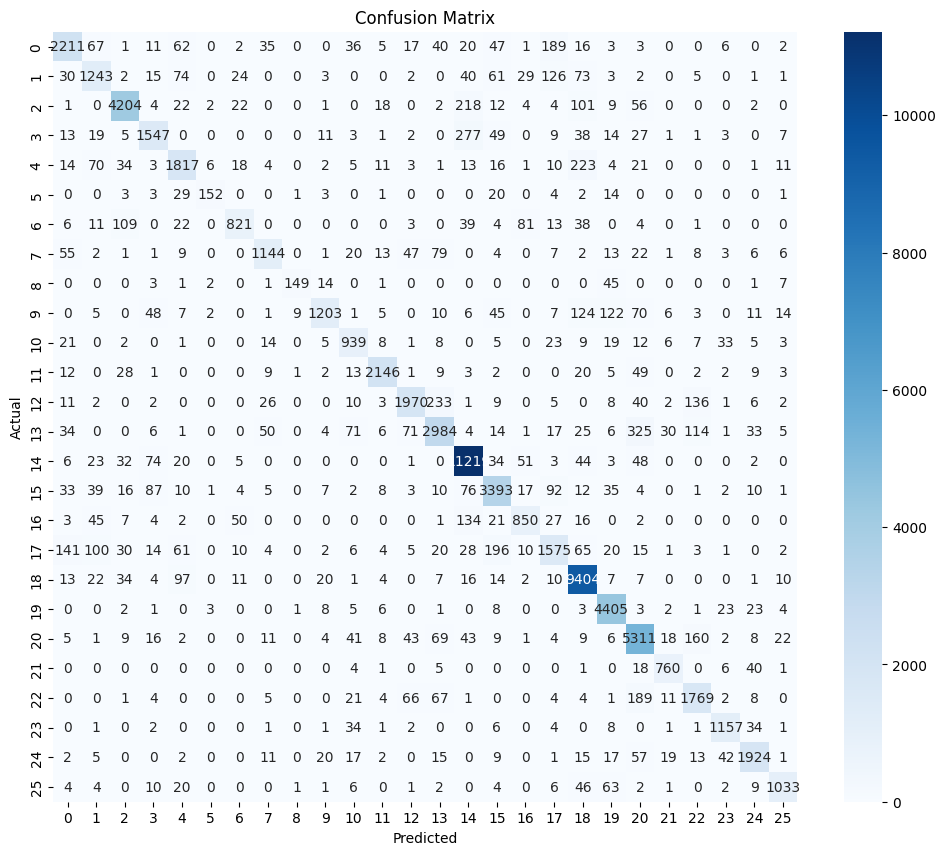

In [54]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**4- ROC & AUC for multi-class**

In [57]:
# Convert labels to one-hot
y_test_bin = label_binarize(y_test, classes=range(26))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(26):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

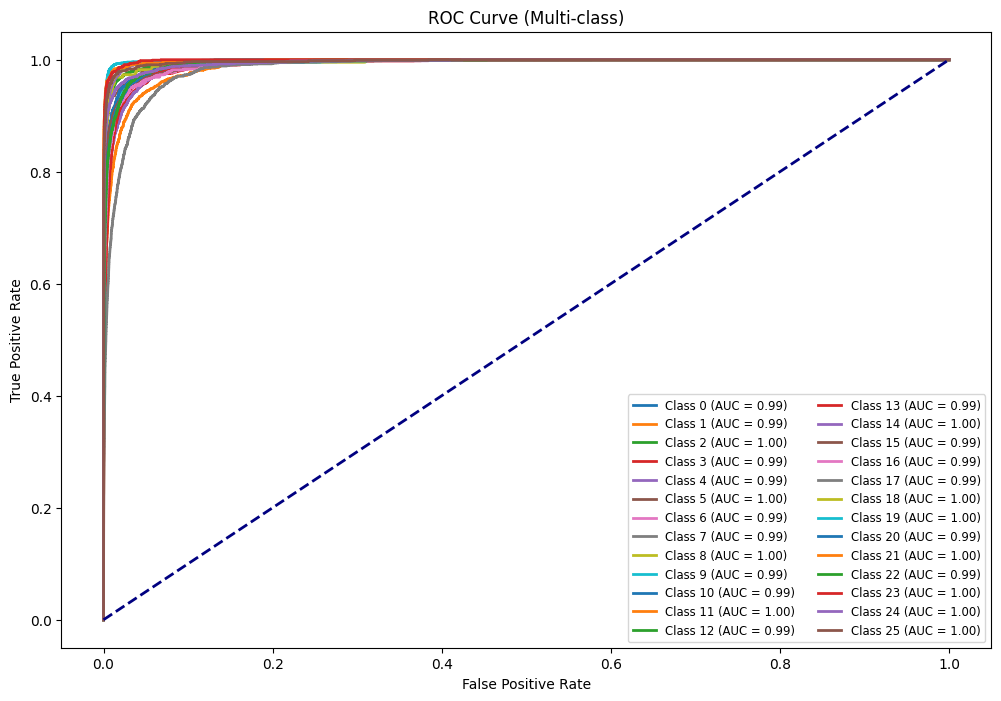

In [58]:
# Plot ROC curve for all classes
plt.figure(figsize=(12,8))
for i in range(26):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multi-class)')
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.show()